In [1]:
import sys
submodule_path = "./lib/TransPath/"
sys.path.append(submodule_path)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from lib.TransPath.data.hmaps import GridData
from lib.TransPath.models.autoencoder_v2 import Autoencoder
from lib.TransPath.modules.planners import DifferentiableDiagAstar

from torch.utils.data import DataLoader
import torch

sns.set_theme()

# Examples

In [30]:
test_data = GridData(
        path='./data/1k_128x2/test/',
        mode="f"
    )
batch_size = 10
dataloader = DataLoader(test_data, batch_size=batch_size,
                        shuffle=True, num_workers=0, pin_memory=False)
samples = next(iter(dataloader))

In [29]:
state_dict_path = "./weights/focals/checkpoints/epoch=159-step=66560.ckpt"
mode = "f"
device = "cpu"

In [8]:
model_focal = Autoencoder(mode=mode)
if ".pth" in state_dict_path:
    checkpoint = torch.load(state_dict_path)
else:
    checkpoint = torch.load(state_dict_path)["state_dict"]
# print(checkpoint["state_dict"].keys())
model_focal.load_state_dict(checkpoint)
model_focal.to(device)
model_focal.eval()

Autoencoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): Conv2d(2, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1-3): 3 x Sequential(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 256, eps=1e-06, affine=True)
          (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(32, 256, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.15, inplace=False)
          (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): Downsample(
          (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2))
        )
      )
    )
  )
  (pos): PosEmbeds(
    (linear): Linear(in_features=4, out_features=256, bias=True)
  )
  (transformer): SpatialTransformer(
    (norm): GroupNorm(32, 256, eps=1e-06, affine=True)
    (proj_in): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (transformer_blocks): ModuleList(
      (0-3): 4 x BasicTransformerBlock

In [31]:
map_design, start, goal, gt_heatmap = samples

inputs_sg = torch.cat([map_design, start + goal], dim=1) if mode == 'f' else torch.cat([map_design, goal], dim=1)
inputs_sg.to(device)

f_planner = DifferentiableDiagAstar(mode='f')
fw100_planner = DifferentiableDiagAstar(mode='f', f_w=100)
w2_planner = DifferentiableDiagAstar(mode='default', h_w=2)
vanilla_planner = DifferentiableDiagAstar(mode='default', h_w=1)

In [32]:
#get predictions and plan results

with torch.no_grad():
    pred_f = (model_focal(inputs_sg) + 1) / 2
    outputs_fw100 = fw100_planner(
                    pred_f,
                    start,
                    goal,
                    (map_design == 0)*1.)

    outputsw2 = w2_planner(
                    (map_design == 0)*1.,
                    start,
                    goal,
                    (map_design == 0)*1.)
    
    outputs_vanilla = vanilla_planner(
                    (map_design == 0)*1.,
                    start,
                    goal,
                    (map_design == 0)*1.)

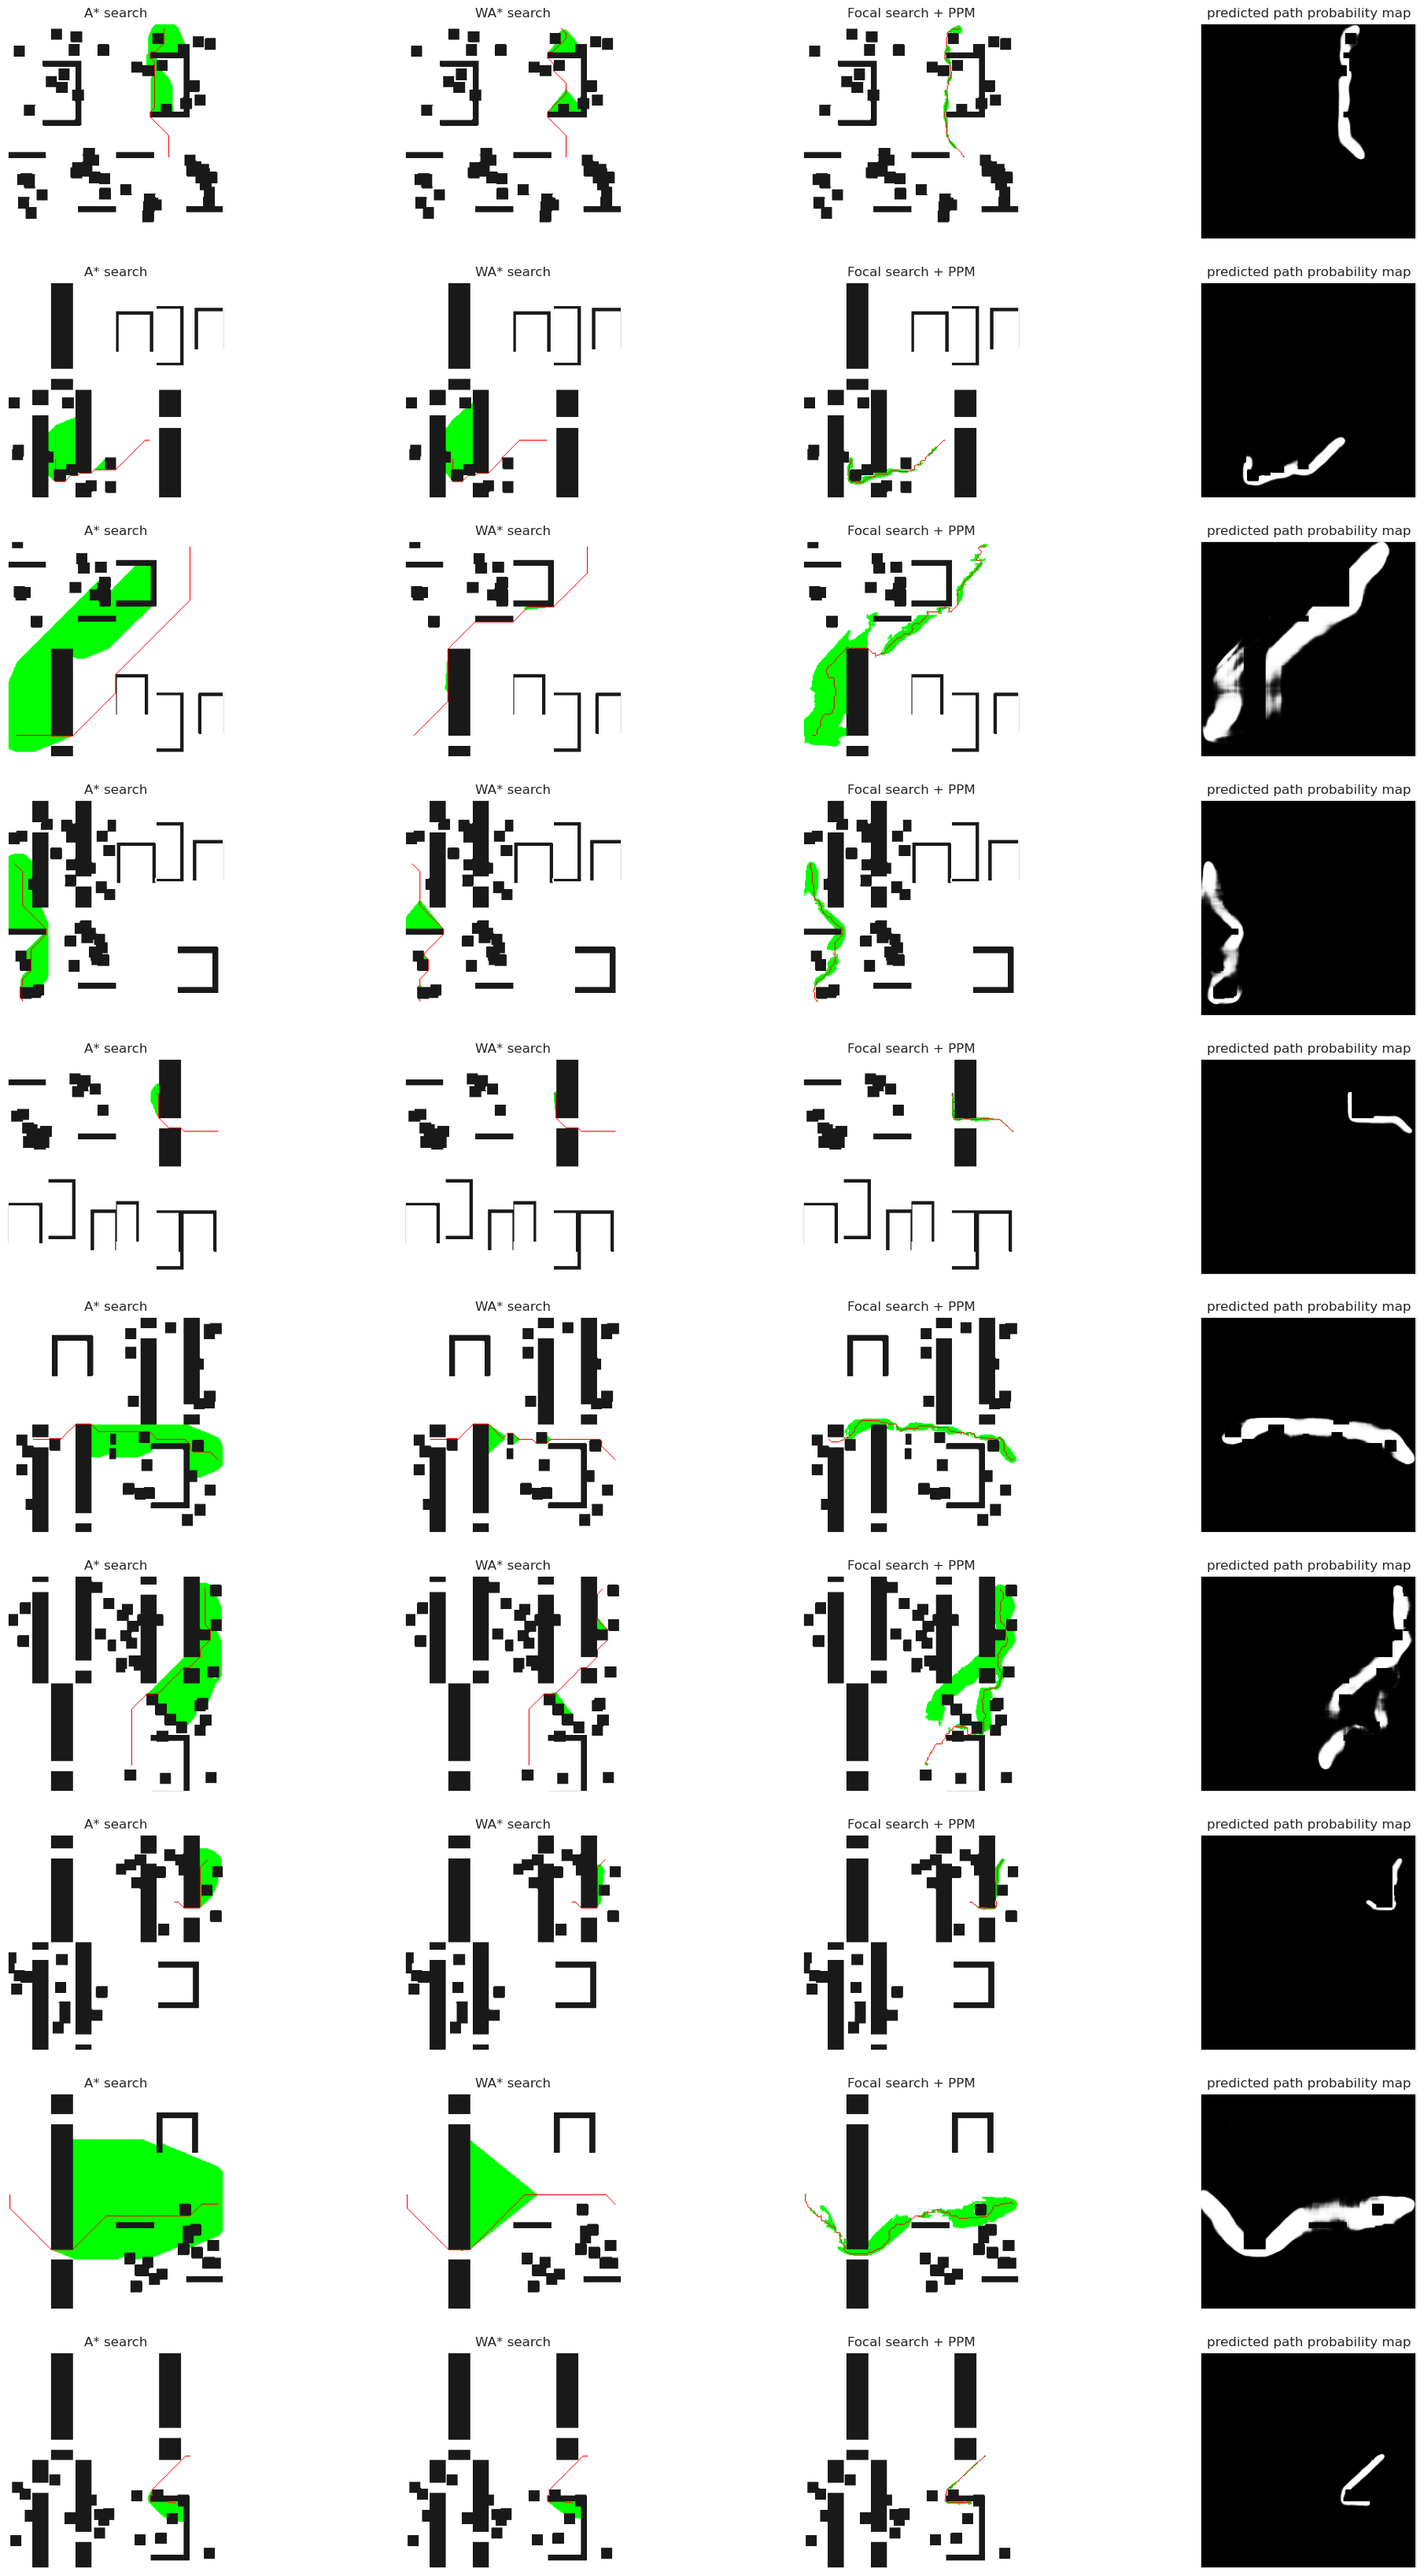

In [33]:
def transform_plan(image):
    result = torch.ones_like(image)
    result[image[:, :, 0] == 1] = torch.tensor([0.1, 0.1, 0.1])
    result[image[:, :, 1] == 1] = torch.tensor([1., 0., 0])
    result[image[:, :, 2] == 1] = torch.tensor([0., 1, 0.])
    return result


fig, ax = plt.subplots(batch_size, 4, figsize=(25, 42))

for i in range(batch_size):
    ax[i][0].imshow(
        transform_plan(torch.moveaxis(torch.cat(
        [map_design, outputs_vanilla.paths, outputs_vanilla.histories - outputs_vanilla.paths], dim=1)[i], 0, 2)))
    ax[i][0].set_xticks([])
    ax[i][0].set_yticks([])
    ax[i][0].set_title(f'A* search')
    
    ax[i][1].imshow(
        transform_plan(torch.moveaxis(torch.cat(
        [map_design, outputsw2.paths, outputsw2.histories - outputsw2.paths], dim=1)[i], 0, 2)))
    ax[i][1].set_xticks([])
    ax[i][1].set_yticks([])
    ax[i][1].set_title(f'WA* search')
    
    ax[i][2].imshow(
        transform_plan(torch.moveaxis(torch.cat(
        [map_design, outputs_fw100.paths, outputs_fw100.histories - outputs_fw100.paths], dim=1)[i], 0, 2)))
    ax[i][2].set_xticks([])
    ax[i][2].set_yticks([])
    ax[i][2].set_title(f'Focal search + PPM')
    
    
    ax[i][3].imshow(pred_f[i, 0], cmap='gray')
    ax[i][3].set_xticks([])
    ax[i][3].set_yticks([])
    ax[i][3].set_title(f'predicted path probability map')


# Evaluated Metrics for focal approach

In [9]:
metrics_cost_path = "./data/metrics/cost_ratio.npy"
metrics_expansions_path = "./data/metrics/expansions_ratio.npy"

costs = np.load(metrics_cost_path) * 100
expansions = np.load(metrics_expansions_path) * 100

In [14]:
arr1inds = costs.argsort()
costs = costs[arr1inds[::-1]]
expansions = expansions[arr1inds[::-1]]

In [36]:
np.stack([costs, expansions]).shape

(2, 860)

In [37]:
df = pd.DataFrame({"costs_ratio":costs, "expansions_ratio":expansions})

### Costs Ratio

In [39]:
df.costs_ratio.describe()

count    860.000000
mean     110.066490
std       22.971220
min       99.999977
25%      103.296669
50%      105.743210
75%      109.986454
max      455.515045
Name: costs_ratio, dtype: float64

In [43]:
df.costs_ratio.median()

105.74320983886719

### Expansions ratio

In [40]:
df.expansions_ratio.describe()

count     860.000000
mean       72.432610
std       244.088715
min         5.317301
25%        20.420755
50%        34.393936
75%        63.898129
max      6149.812500
Name: expansions_ratio, dtype: float64

In [42]:
df.expansions_ratio.median()

34.39393615722656

### Visualisation

Text(0.5, 0, 'Expansions ratio')

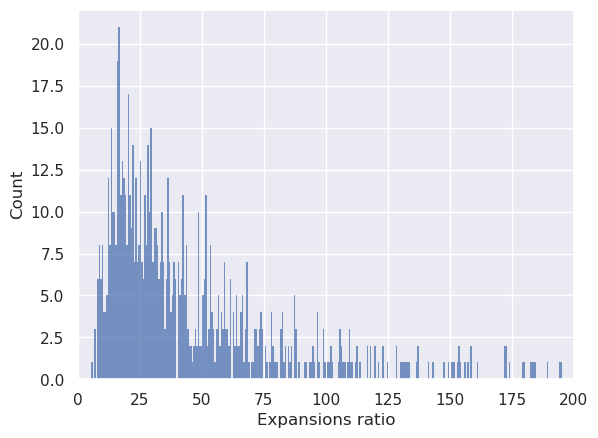

In [25]:
sns.histplot(expansions, bins=10000)
plt.xlim((0, 200))
# plt.ylim((0,8))

plt.xlabel("Expansions ratio")

Text(0, 0.5, 'Expansions ratio')

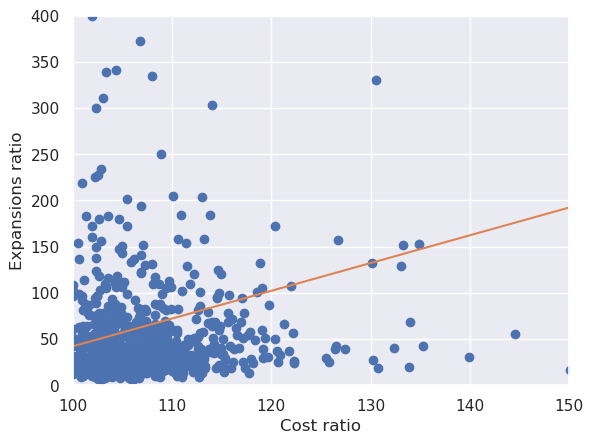

In [24]:
plt.plot(costs, expansions, 'o')

m, b = np.polyfit(costs, expansions, 1)

plt.plot(costs, m*costs+b)

plt.xlim((100, 150))
plt.ylim((0 , 400)) 

plt.xlabel("Cost ratio")
plt.ylabel("Expansions ratio")